・勾配で、計算量のプロットを作る
・global parameter（n_latent, sess, mnistなど）を消す

In [41]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pickle

#import scipy.stats
#import math
import time
from IPython import display

In [42]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [43]:
#X_in = tf.placeholder(dtype=float_type, shape=[None, 28, 28], name='X')
#X0 = tf.reshape(X_in,[-1, 1, 28, 28])
drop_rate = 0.2
#with tf.name_scope("decoder"):
#    n_beta = tf.Variable(1., 'n_beta', dtype=float_type) #variance of image output

n_latent = 5
dec_in_channels = 1



# hyper paremeters depending on models
batch_size = 100
n_MC = {}
loss = {}
optimizer = {}

In [44]:
#utility funcs
float_type = np.float32

tf_int32 = lambda x:tf.cast(x, tf.int32)
tf_float = lambda x:tf.cast(x, float_type)

def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

def tf_reduce_logmeanexp(ary, axis=1):
    n_MC = tf.shape(ary)[axis]
    return tf.reduce_logsumexp(ary, axis=axis) - tf.log(tf_float(n_MC))

def tf_sum(_list):
    S = 0
    for val in _list:
        S += val
    return val

def save(data_obj, name):
    with open(name, mode='wb') as f:
        pickle.dump(data_obj, f)
        
def load(name):
    with open(name, mode='rb') as f:
        data_obj = pickle.load(f)
    return data_obj

In [45]:
class CVAE(tf.keras.Model):
    
    def __init__(self, latent_dim, drop_rate):
        
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.drop_rate = drop_rate
        
        self.inference_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=4, strides=2, padding='same', activation=lrelu),
            tf.keras.layers.Dropout(rate=drop_rate),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=4, strides=2, padding='same', activation=lrelu),
            tf.keras.layers.Dropout(rate=drop_rate),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=4, strides=1, padding='same', activation=lrelu),
            tf.keras.layers.Dropout(rate=drop_rate),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])
        
        self.generative_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),
            tf.keras.layers.Dense(units=7*7*dec_in_channels//2, activation=lrelu),
            tf.keras.layers.Dense(units=7*7*dec_in_channels, activation=lrelu),
            tf.keras.layers.Reshape([7, 7, dec_in_channels]),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=2, padding='same', activation=None),
            #tf.keras.layers.Dropout(rate=drop_rate),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=1, padding='same', activation=None),
            #tf.keras.layers.Dropout(rate=drop_rate),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=1, padding='same', activation=lrelu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(28*28, activation=tf.nn.sigmoid),
            tf.keras.layers.Reshape([28,28,1])
        ])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [46]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [47]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim, drop_rate=0.2)

In [48]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 100, Test set ELBO: -534.1044311523438, time elapse for current epoch 8.284930944442749


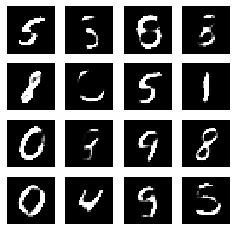

In [49]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
        end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
    'time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(
    model, epoch, random_vector_for_generation)

In [ ]:
model = CVAE(latent_dim, drop_rate=0.2)
model.inference_net(np.zeros([1,28,28], dtype=np.float32)).shape

In [ ]:
@tf.function
def encoder(X, keep_prob, n_latent):
    activation = lrelu
    n_X = tf.shape(X)[0]
    with tf.name_scope("encoder"):
        x = tf.reshape(X, shape=[n_X, 28, 28, 1])
        x = tf.keras.layers.Conv2D(name='1', filters=64, kernel_size=4, strides=2, padding='same', activation=activation)(x)
        x = tf.keras.layers.Dropout(keep_prob, name='2')(x)
        x = tf.keras.layers.Conv2D(name='3', filters=64, kernel_size=4, strides=2, padding='same', activation=activation)(x)
        x = tf.keras.layers.Dropout(keep_prob, name='4')(x)
        x = tf.keras.layers.Conv2D(name='5', filters=64, kernel_size=4, strides=1, padding='same', activation=activation)(x)
        x = tf.keras.layers.Dropout(keep_prob, name='6')(x)
        x = tf.keras.layers.Flatten()(x)
        
        mu_Z = tf.keras.layers.Dense(name='7', units=n_latent)(x)
        mu_Z = tf.reshape(mu_Z, [n_X, 1, n_latent])
        sigma_Z = tf.math.softplus(0.5 * tf.keras.layers.Dense(name='8', units=n_latent)(x) )
        sigma_Z = tf.reshape(sigma_Z, [n_X, 1, n_latent])
        return mu_Z, sigma_Z

In [ ]:
@tf.function
def encoder(X, keep_prob):
    activation = lrelu
    n_X = tf.shape(X)[0]
    with tf.name_scope("encoder"):
        x = tf.reshape(X, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, name='1', filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob, name='2')
        x = tf.layers.conv2d(x, name='3', filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob, name='4')
        x = tf.layers.conv2d(x, name='5', filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob, name='6')
        x = tf.contrib.layers.flatten(x)
        
        mu_Z = tf.layers.dense(x, name='7', units=n_latent)
        mu_Z = tf.reshape(mu_Z, [n_X, 1, n_latent])
        sigma_Z = tf.exp(0.5 * tf.layers.dense(x, name='8', units=n_latent) )
        sigma_Z = tf.reshape(sigma_Z, [n_X, 1, n_latent])
        return mu_Z, sigma_Z

@tf.function
def decoder(Z, keep_prob):
    activation = lrelu
    n_X = tf.shape(Z)[0]
    n_MC = tf.shape(Z)[1]
    with tf.name_scope("decoder", reuse=tf.AUTO_REUSE):
        x = tf.keras.layers.Dense(name='1', units=7*7*dec_in_channels//2, activation=activation)(Z)
        x = tf.keras.layers.Dense(name='2' ,units=7*7*dec_in_channels, activation=activation)(x)
        x = tf.reshape(x, [n_X*n_MC, 7, 7, dec_in_channels])
        x = tf.keras.layers.Convolution2DTranspose(x, name='3', filters=64, kernel_size=4, strides=2, padding='same', activation=activation)(x)
        x = tf.nn.dropout(x, keep_prob, name='4')(x)
        x = tf.keras.layers.Convolution2DTranspose(x, name='5', filters=64, kernel_size=4, strides=1, padding='same', activation=activation)(x)
        x = tf.nn.dropout(x, keep_prob, name='6')(x)
        x = tf.keras.layers.Convolution2DTranspose(x, name='7', filters=64, kernel_size=4, strides=1, padding='same', activation=activation)(x)
        x = tf.reshape(x, [n_X, n_MC, 14*14*64*dec_in_channels])
        x = tf.keras.layers.Dense(x, name='8', units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[n_X, n_MC, 28, 28])
        return img

In [ ]:
def decoder(Z, keep_prob):
    activation = lrelu
    n_X = tf.shape(Z)[0]
    n_MC = tf.shape(Z)[1]
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
        x = tf.layers.dense(Z, name='1', units=7*7*dec_in_channels//2, activation=activation)
        x = tf.layers.dense(x, name='2' ,units=7*7*dec_in_channels, activation=lrelu)
        x = tf.reshape(x, [n_X*n_MC, 7, 7, dec_in_channels])
        x = tf.layers.conv2d_transpose(x, name='3', filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob, name='4')
        x = tf.layers.conv2d_transpose(x, name='5', filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob, name='6')
        x = tf.layers.conv2d_transpose(x, name='7', filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.reshape(x, [n_X, n_MC, 14*14*64*dec_in_channels])
        x = tf.layers.dense(x, name='8', units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[n_X, n_MC, 28, 28])
        return img

In [ ]:
for d in train_dataset:
    print(d.shape)
    break

In [ ]:
encoder(d, 0.8, 5)

### ELBO

In [ ]:
def ELBO(X, Z, mu_Z, sigma_Z): 
    
    n_latent = tf.shape(Z)[2]
    
    quad_pz_ary = tf.reduce_sum( -1./2. * Z**2, axis=2) #shape: [batch_size, n_MC]
    quad_qz_ary = tf.reduce_sum( +1./(2. * sigma_Z**2) * (Z - mu_Z)**2, axis=2) #shape: [batch_size, n_MC]
    quad_px_ary = tf.reduce_sum( -1./(2. * sigma_X**2) * (mu_X - X)**2, axis=[2,3]) #shape: [batch_size, n_MC]

    #MC est. of E_q [logp(X|Z)] w.r.t. X, Z
    img_loss = - (- (1/2.)* 28*28 *       tf.log(2 * math.pi * sigma_X**2)          + quad_px_ary \
                  + (1/2.)*tf.reduce_sum( tf.log(2 * math.pi * sigma_Z**2), axis=2) + quad_qz_ary)
    img_loss = tf.reduce_mean(img_loss)#squeeze dim of n_MC

    #E_q [P(Z) - logq(Z|X)] analytical value, 
    #it is a negative KL divergence (not between p(Z|X) and q(Z|X))
    latent_loss = - (- (1/2.)*tf_float(n_latent)*np.log(2 * math.pi) + quad_pz_ary) 
    latent_loss = tf.reduce_mean(latent_loss) #squeeze dim of n_MC

    return -(img_loss+latent_loss), img_loss, latent_loss

In [ ]:
def ELBO(mu_X, X, Z, mu_Z, sigma_Z): 
    
    n_latent = tf.shape(Z)[2]
    
    quad_pz_ary = tf.reduce_sum( -1./2. * Z**2, axis=2) #shape: [batch_size, n_MC]
    quad_qz_ary = tf.reduce_sum( +1./(2. * sigma_Z**2) * (Z - mu_Z)**2, axis=2) #shape: [batch_size, n_MC]
    quad_px_ary = tf.reduce_sum( -1./(2. * sigma_X**2) * (mu_X - X)**2, axis=[2,3]) #shape: [batch_size, n_MC]

    #MC est. of E_q [logp(X|Z)] w.r.t. X, Z
    img_loss = - (- (1/2.)* 28*28 *       tf.log(2 * math.pi * sigma_X**2)          + quad_px_ary \
                  + (1/2.)*tf.reduce_sum( tf.log(2 * math.pi * sigma_Z**2), axis=2) + quad_qz_ary)
    img_loss = tf.reduce_mean(img_loss)#squeeze dim of n_MC

    #E_q [P(Z) - logq(Z|X)] analytical value, 
    #it is a negative KL divergence (not between p(Z|X) and q(Z|X))
    latent_loss = - (- (1/2.)*tf_float(n_latent)*np.log(2 * math.pi) + quad_pz_ary) 
    latent_loss = tf.reduce_mean(latent_loss) #squeeze dim of n_MC

    return -(img_loss+latent_loss), img_loss, latent_loss

### IWAE loss

In [ ]:
def pointwise_IWELBO(mu_X, X, Z, mu_Z, sigma_Z):    
    
    #Importance MC est. of E_p[ "exp. part of P(X|z)" ] given X w.r.t. Z
    #for numerical stability, a little complicated
    
    n_X = tf.shape(X)[0]
    n_latent = tf.shape(mu_Z)[2]
    
    quad_pz_ary = tf.reduce_sum( 1./2. * Z**2, axis=2) #shape: [batch_size, n_MC]
    quad_qz_ary = tf.reduce_sum( 1./(2. * sigma_Z**2) * (Z - mu_Z)**2, axis=2) #shape: [batch_size, n_MC]
    quad_px_ary = tf.reduce_sum( 1./(2. * sigma_X**2) * (X - mu_X)**2, axis=[2,3]) #shape: [batch_size, n_MC]
    
    quad_ary = - quad_pz_ary + quad_qz_ary - quad_px_ary
    
    IWELBO = (1/2.) * tf.reduce_sum( tf.reshape(tf.log(sigma_Z**2), [n_X, n_latent]), axis=1)\
           - (1/2.)*28*28 * tf.log(2 * math.pi * sigma_X**2)\
           + tf_reduce_logmeanexp(quad_ary, axis=1)

    return IWELBO #shape: [batch_size] 

### Variational Bounds

In [ ]:
def pointwise_gamma_div(mu_X, X, Z, mu_Z, sigma_Z, gamma):    
    
    #Importance MC est. of E_p[ "exp. part of P(X|z)" ] given X w.r.t. Z
    #for numerical stability, a little complicated
    
    n_X = tf.shape(X)[0]
    n_latent = tf.shape(Z)[2]

    quad_pz_ary = tf.reduce_sum( 1./2. * Z**2, axis=2) #shape: [batch_size, n_MC]
    quad_qz_ary = tf.reduce_sum( 1./(2. * sigma_Z**2) * (Z - mu_Z)**2, axis=2) #shape: [batch_size, n_MC]
    quad_px_ary = tf.reduce_sum( 1./(2. * sigma_X**2) * (X - mu_X)**2, axis=[2,3]) #shape: [batch_size, n_MC]
    
    quad_ary = - quad_pz_ary + quad_qz_ary - quad_px_ary
    
    gamma_div = (1/2.) * tf.reduce_sum( tf.reshape(tf.log(sigma_Z**2), [n_X, n_latent]), axis=1)\
           - (1/2.)*28*28 * tf.log(2 * math.pi * sigma_X**2)\
           + (1/gamma) * tf_reduce_logmeanexp(gamma * quad_ary, axis=1)

    return gamma_div #shape: [batch_size] 

In [ ]:
pointwise_Pearson_UBO = lambda mu_X, X, Z, mu_Z, sigma_Z: pointwise_gamma_div(mu_X, X, Z, mu_Z, sigma_Z, gamma=2.)
pointwise_Hellinger_LBO = lambda mu_X, X, Z, mu_Z, sigma_Z: pointwise_gamma_div(mu_X, X, Z, mu_Z, sigma_Z, gamma=0.5)
pointwise_Neyman_LBO = lambda mu_X, X, Z, mu_Z, sigma_Z: pointwise_gamma_div(mu_X, X, Z, mu_Z, sigma_Z, gamma=-1.)

In [ ]:
def pointwise_reversed_gamma_div(mu_X, X, Z, mu_Z, sigma_Z, gamma):    
    
    #Importance MC est. of E_p[ "exp. part of P(X|z)" ] given X w.r.t. Z
    #for numerical stability, a little complicated
    
    n_X = tf.shape(X)[0]
    n_latent = tf.shape(Z)[2]

    quad_pz_ary = tf.reduce_sum( 1./2. * Z**2, axis=2) #shape: [batch_size, n_MC]
    quad_qz_ary = tf.reduce_sum( 1./(2. * sigma_Z**2) * (Z - mu_Z)**2, axis=2) #shape: [batch_size, n_MC]
    quad_px_ary = tf.reduce_sum( 1./(2. * sigma_X**2) * (X - mu_X)**2, axis=[2,3]) #shape: [batch_size, n_MC]
    
    quad_ary = - quad_pz_ary + quad_qz_ary - quad_px_ary
    
    first_term = -((gamma-1)/2.) * tf.reduce_sum( tf.reshape(tf.log(sigma_Z**2), [n_X, n_latent]), axis=1)\
           + ((gamma-1)/2.)*28*28 * tf.log(2 * math.pi * sigma_X**2)\
           + tf_reduce_logmeanexp( - (gamma-1) * quad_ary, axis=1)
    first_term *= - (1/gamma)
    
    second_term = (1/2.) * tf.reduce_sum( tf.reshape(tf.log(sigma_Z**2), [n_X, n_latent]), axis=1)\
           - (1/2.)*28*28 * tf.log(2 * math.pi * sigma_X**2)\
           + tf_reduce_logmeanexp(quad_ary, axis=1)
    second_term *= (1/gamma)

    return first_term + second_term #shape: [batch_size] 

In [ ]:
pointwise_Pearson_LBO = lambda mu_X, X, Z, mu_Z, sigma_Z: pointwise_reversed_gamma_div(mu_X, X, Z, mu_Z, sigma_Z, gamma=2.)
pointwise_Hellinger_UBO = lambda mu_X, X, Z, mu_Z, sigma_Z: pointwise_reversed_gamma_div(mu_X, X, Z, mu_Z, sigma_Z, gamma=0.5)
pointwise_Neyman_UBO = lambda mu_X, X, Z, mu_Z, sigma_Z: pointwise_reversed_gamma_div(mu_X, X, Z, mu_Z, sigma_Z, gamma=-1.)

In [ ]:
def pointwise_reversed_KL_UBO(mu_X, X, Z, mu_Z, sigma_Z):    
    
    #Importance MC est. of E_p[ "exp. part of P(X|z)" ] given X w.r.t. Z
    #for numerical stability, a little complicated
    
    n_X = tf.shape(X)[0]
    n_latent = tf.shape(Z)[2]

    quad_pz_ary = tf.reduce_sum( 1./2. * Z**2, axis=2) #shape: [batch_size, n_MC]
    quad_qz_ary = tf.reduce_sum( 1./(2. * sigma_Z**2) * (Z - mu_Z)**2, axis=2) #shape: [batch_size, n_MC]
    quad_px_ary = tf.reduce_sum( 1./(2. * sigma_X**2) * (X - mu_X)**2, axis=[2,3]) #shape: [batch_size, n_MC]
    
    quad_ary = - quad_pz_ary + quad_qz_ary - quad_px_ary
    
    log_w = (1/2.) * tf.reduce_sum( tf.reshape(tf.log(sigma_Z**2), [n_X, n_latent,1]), axis=1)\
           - (1/2.)*28*28 * tf.log(2 * math.pi * sigma_X**2)\
           + quad_ary
    reversed_KL = tf.nn.softmax(log_w, axis=1)*log_w #shape: [batch_size, n_MC]
    reversed_KL = tf.reduce_sum(reversed_KL, axis=1)
    
    return reversed_KL #shape: [batch_size] 

In [ ]:
def pointwise_mutual_information(mu_X, X, Z, mu_Z, sigma_Z):    
    
    #Importance MC est. of E_p[ "exp. part of P(X|z)" ] given X w.r.t. Z
    #for numerical stability, a little complicated
    
    n_X = tf.shape(X)[0]
    n_latent = tf.shape(Z)[2]

    quad_pz_ary = tf.reduce_sum( 1./2. * Z**2, axis=2) #shape: [batch_size, n_MC]
    quad_qz_ary = tf.reduce_sum( 1./(2. * sigma_Z**2) * (Z - mu_Z)**2, axis=2) #shape: [batch_size, n_MC]
    quad_px_ary = tf.reduce_sum( 1./(2. * sigma_X**2) * (X - mu_X)**2, axis=[2,3]) #shape: [batch_size, n_MC]
    
    quad_ary = - quad_pz_ary + quad_qz_ary - quad_px_ary
    
    log_w = (1/2.) * tf.reduce_sum( tf.reshape(tf.log(sigma_Z**2), [n_X, n_latent,1]), axis=1)\
             - (1/2.)*28*28 * tf.log(2 * math.pi * sigma_X**2)\
             + quad_ary
    log_px = - (1/2.)*28*28 * tf.log(2 * math.pi * sigma_X**2)\
             - quad_px_ary
    first_term = tf.nn.softmax(log_w, axis=1)*log_px #shape: [batch_size, n_MC]
    first_term = tf.reduce_sum(first_term, axis=1) 
    second_term = - pointwise_IWELBO(mu_X, X, Z, mu_Z, sigma_Z)
    
    return first_term + second_term#shape: [batch_size] 

### MLMC IWAE loss (non-adaptive, heuristic)

In [ ]:
def pointwise_psi(l, X, pointwise_nested):

    n_MC = 2**l
    n_X = tf.shape(X)[0]
    
    mu_Z, sigma_Z = encoder(X, keep_prob)
    Z = Z_sampler(mu_Z, sigma_Z, n_MC)
    mu_X = decoder(Z, keep_prob)
    
    nested_whole = pointwise_nested(mu_X, X, Z, mu_Z, sigma_Z)

    Z_1st_half = Z[:, :n_MC//2 , :]
    Z_2nd_half = Z[:,  n_MC//2:, :]
    
    mu_X_1st_half = mu_X[:, :n_MC//2 , :, :]
    mu_X_2nd_half = mu_X[:,  n_MC//2:, :, :]
    
    nested_1st_half = pointwise_nested(mu_X_1st_half, X, Z_1st_half, mu_Z, sigma_Z)
    nested_2nd_half = pointwise_nested(mu_X_2nd_half, X, Z_2nd_half, mu_Z, sigma_Z)
    
    #psis is a [batch_size] dimentional tensor 
    pointwise_psi = nested_whole - (1./2.) * ( nested_1st_half + nested_2nd_half )
    return pointwise_psi

In [ ]:
def MLMC_est(X, pointwise_nested, start_level, max_level, n_X, verbose=False): 

    levels = list(range(start_level, max_level+1))
    Ns = {}
    Cs = {}
    NCs = {}
    weight = np.array([2**(-3/2*l) for l in range(max_level+1)])
    weight[:start_level] = 0
    
    for l in levels:
        Ns[l] = math.ceil( (weight[l]/weight.sum()) * n_X ) 
        Cs[l] = 2**l
        NCs[l] = Ns[l]*Cs[l]
    
    Ns[start_level] = n_X - sum([Ns[l] for l in levels[1:]])
    if verbose:
        print( {'N':Ns, 'C':Cs, 'NC':NCs, 'total_cost':sum(NCs.values())})
    #MC est. of - E_p[log E_p[P(X|Z_sample)] |X ] w.r.t. X, psi_sample
    
    mu_Z, sigma_Z = encoder(X[:Ns[start_level]], keep_prob)
    Z = Z_sampler(mu_Z, sigma_Z, Cs[start_level])
    mu_X = decoder(Z, keep_prob)
    
    obj = tf.reduce_mean( pointwise_nested(mu_X, X[:Ns[start_level]], Z, mu_Z, sigma_Z) )
    
    for l in levels[1:]:
        start_idx = sum(list(Ns.values())[:l-start_level])
        obj += tf.reduce_mean( pointwise_psi(l, X[start_idx : start_idx+Ns[l]], pointwise_IWELBO) )
        
    return obj

In [ ]:
?train_images

In [ ]:
#decode, sample, encode
X = train_images.
mu_Z, sigma_Z = encoder(X, keep_prob)
Z = Z_sampler(mu_Z, sigma_Z, n_MC=1)
mu_X = decoder(Z, keep_prob)

_, latent_loss, img_loss = ELBO(mu_X, X, Z, mu_Z, sigma_Z)
loss['ELBO'] = latent_loss + img_loss

In [ ]:
#decode, sample, encode
X = X0[:8]
mu_Z, sigma_Z = encoder(X, keep_prob)
Z = Z_sampler(mu_Z, sigma_Z, n_MC=32)
mu_X = decoder(Z, keep_prob)

IWELBO = pointwise_IWELBO(mu_X, X, Z, mu_Z, sigma_Z)
loss['IWELBO'] = - tf.reduce_mean(IWELBO)

In [ ]:
loss['MLMC-IWELBO'] = - MLMC_est(X0, pointwise_nested=pointwise_IWELBO, start_level=1, max_level=5, n_X=50, verbose=True) 

### Reconsrtruction based on importance sampling / Random Image Generation

In [ ]:
X = X0[:1,:1,:,:]
mu_Z,sigma_Z = encoder(X, keep_prob=1)
reconstructed = decoder(mu_Z, keep_prob=1)

Z = Z_sampler(tf.constant(np.zeros([1,1,n_latent],dtype=float_type)), 1, 1)
generated = decoder(Z, keep_prob=1)

## Training the network

In [ ]:
def optimizing_ops(loss_p=None, loss_q=None, alpha_p=0.0005, alpha_q=0.0005):

    optimizer_p = tf.train.AdamOptimizer(alpha_p, name='optimizer')
    optimizer_q = tf.train.AdamOptimizer(alpha_q, name='optimizer')
    
    
    ops = []
    
    if loss_p is not None:
        ops.append(  )
    if loss_q is not None:
        ops.append( optimizer_q.minimize(loss_q, var_list=param_enc) )
    return ops

In [ ]:
optimizer = tf.train.AdamOptimizer(0.0005, name='optimizer')

param_dec = tf.trainable_variables(scope='decoder')
param_enc = tf.trainable_variables(scope='encoder')

op_elbo_p = optimizer.minimize(loss['ELBO'], var_list=param_dec)
op_elbo_q = optimizer.minimize(loss['ELBO'], var_list=param_enc)

ops = [op_elbo_q, op_elbo_p]

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
plt.figure(figsize=[16,16])
n_iter = 1000
losses = []

for i in range(n_iter):
    batch = mnist.train.next_batch(batch_size=64)[0].reshape([-1,28,28])
    _ = sess.run(ops, feed_dict = {X_in: batch, keep_prob: 0.8})
        
    if 0 == i % (n_iter//50):
        j = i//(n_iter//50)
        ls, r, i_ls, l_ls = sess.run([loss['ELBO'], reconstructed, img_loss, latent_loss], feed_dict = {X_in: batch, keep_prob: 1.0})
        losses.append(ls)
        plt.subplot(10,10,j//10*20+j%10+1)
        plt.axis('off')
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.title('#epoch:%0.0d'%(i))
        plt.subplot(10,10,j//10*20+10+j%10+1)
        plt.axis('off')
        plt.imshow(r[0,0,:,:], cmap='gray')
        print("#epochs:%0.0d,\tloss:%0.2f,\timage_loss:%0.2f,\tlatent_loss:%0.2f"%(i, ls, np.mean(i_ls), np.mean(l_ls)))
    
plt.show()

## MLMC condition check

### Check the variance of loss

In [ ]:
def train_model(ops, n_step):
    for i in range(n_step):
        batch = mnist.train.next_batch(batch_size=batch_size)[0]
        batch = batch.reshape([-1,28,28])
        sess.run(ops, feed_dict = {X_in: batch, keep_prob: 0.8})

In [ ]:
def get_dec_cost_mlmc(start_level, max_level, n_X):
    levels = list(range(start_level, max_level+1))
    Ns = {}
    Cs = {}
    NCs = {}
    weight = np.array([2**(-3/2*l) for l in range(max_level+1)])
    weight[:start_level] = 0

    for l in levels:
        Ns[l] = math.ceil( (weight[l]/weight.sum()) * n_X ) 
        Cs[l] = 2**l
        NCs[l] = Ns[l]*Cs[l]
    
    return (sum(list(NCs.values())))

def eval_mean_and_var(obj_list, n_sample):
    mean_list = []
    var_list = []
    for obj in obj_list:
        batches = [mnist.test.next_batch(batch_size=batch_size)[0].reshape([-1,28,28]) for i in range(n_sample)]
        vals = [sess.run([obj], feed_dict = {X_in: batch, keep_prob: 1.0}) for batch in batches]
        mean_list.append(np.mean(vals))
        var_list.append(np.var(vals))
    return mean_list, var_list

def eval_standard_complexity(pointwise_nested, start_level, max_level, n_sample=20):
    X = X0[:10]
    psis = []
    nested = []
    mlmc = []
    
    dec_cost_nested = []
    enc_cost_nested = []
    dec_cost_mlmc = []
    enc_cost_mlmc = []
    
    for l in range(start_level,max_level+1):
        
        mu_Z, sigma_Z = encoder(X, keep_prob)
        Z = Z_sampler(mu_Z, sigma_Z, 2**l)
        mu_X = decoder(Z, keep_prob)
        
        psis.append( tf.reduce_mean( pointwise_psi(l+1, X, pointwise_nested) ) )
        nested.append( tf.reduce_mean( pointwise_nested(mu_X, X, Z, mu_Z, sigma_Z) ) ) 
        mlmc.append( MLMC_est(tf.reshape(X0[:100], [100, 1, 28, 28]), pointwise_nested=pointwise_IWELBO, start_level=start_level, max_level=l, n_X=100) )

        dec_cost_nested.append(10)
        enc_cost_nested.append(10*2**l)
        dec_cost_mlmc.append(100)
        enc_cost_mlmc.append( get_dec_cost_mlmc(start_level, l, n_X=100) )
        
    mean_psi, var_psi    = eval_mean_and_var(psis, n_sample)
    _,        var_nested = eval_mean_and_var(nested, n_sample)
    _,        var_mlmc   = eval_mean_and_var(mlmc, n_sample)
    
    cost_nested = np.array(enc_cost_nested) * (np.array(var_nested) / (4 * np.array(var_psi + np.array(mean_psi)**2)))
    cost_mlmc   = np.array(enc_cost_mlmc  ) * (np.array(var_mlmc  ) / (4 * np.array(var_psi + np.array(mean_psi)**2)))

    #print(var_nested)
    #print(var_mlmc)
    #print(var_psi)
    
    #print(enc_cost_nested)
    #print(enc_cost_mlmc)
    
    return np.array([4 * np.sqrt(var_psi + np.array(mean_psi)**2), cost_nested, cost_mlmc]).T

In [ ]:
def plot_cost_accuracy(pointwise_nested, obj_name, start_level=0, max_level=7, n_sample=100):
    r = eval_standard_complexity(pointwise_nested, start_level, max_level, n_sample)
    x = r[:,0]/max(r[:,0])
    x0 = x[0]
    y = r[:,[1,2]]
    y0 = y[0,:] = np.mean(y[0,:])
    plt.plot(x,y)
    plt.plot(x0*2.**(-np.arange(len(x))), y0*2.**(2*np.arange(len(y))), color='gray')
    plt.plot(x0*2.**(-np.arange(len(x))), y0*2.**(3*np.arange(len(y))), color='gray')
    plt.xlim([max(x)*1.1, min(x)*0.9])
    plt.ylim([min(y[:,0])*0.5, max(y[:,0])*2])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('relative accuracy: epsilon')
    plt.ylabel('required cost')
    plt.legend(['cost of nested estimator', 'cost of MLMC estimator', 'O(1/epsilon^2)', 'O(1/epsilon^3)'])
    plt.savefig('../out/plot/cost_accuracy_{}.eps'.format(obj_name))
    save(r, '../out/log/cost_accuracy_{}.pickle'.format(obj_name))

### Check of the order of psi (difference of estimators between levels) and IWELBO

In [ ]:
def plot_convergenvce(pointwise_nested, start_level, max_level, n_sample=20, figname=None):
    
    levels = np.arange(start_level,max_level+1)
    psis = []
    
    for l in levels:
        psis.append( tf.reduce_mean( pointwise_psi(l, X0[:10], pointwise_nested) ) )
    
    mean_psi, var_psi = eval_mean_and_var(psis, n_sample)
    var_psi = np.array(var_psi)*10
    mean_abs_psi = np.abs(mean_psi)
    
    plt.figure(figsize=[8,6])
    plt.plot(levels,var_psi)
    plt.plot(levels,mean_abs_psi)
    plt.plot(levels,[var_psi[0]*2.**(-2*l) for l in range(len(levels))],c='gray')
    plt.plot(levels,[mean_abs_psi[0]*2.**(-l) for l in range(len(levels))],c='gray')
    plt.yscale('log')
    plt.ylabel('variance')
    plt.xlabel('level')
    plt.legend([
        'Var_X[ psi_l(X) ]\n',
        '|E_X[ psi_l(X) ]|\n',
        'O(2^(-2l))', 'O(2^(-l))'
    ])
    if figname is not None:
        plt.savefig('../out/plot/psi_convergence_{}.eps'.format(figname))
        save(np.array([var_psi, mean_abs_psi]), '../out/log/psi_convergence_{}.pickle'.format(figname))

### Check the variance of gradient

In [ ]:
def eval_mean_and_var_grad(obj, n_sample):
    
    mean_list = []
    var_list = []
    
    g = tf.train.GradientDescentOptimizer(0.0005)
    grads = g.compute_gradients(obj)
    grads_flat = tf.concat([tf.reshape(g_tuple[0],[-1]) for g_tuple in grads], axis=0)
    
    mean = 0
    mean_sq = 0
    for i in range(n_sample):
        batch = mnist.test.next_batch(batch_size=batch_size)[0].reshape([-1,28,28])
        tmp_grads = np.float64(sess.run(grads_flat, feed_dict = {X_in: batch, keep_prob: 1.0}))
        mean    += (1/n_sample) * np.abs(tmp_grads)
        mean_sq += (1/n_sample) * tmp_grads**2
    var = mean_sq - mean**2
    
    return mean, var

In [ ]:
def plot_convergenvce_grad(pointwise_nested, start_level, max_level, n_sample=20, figname=None):
    
    levels = np.arange(start_level,max_level+1)
    moment2 = []
    moment1 = []
    
    for l in levels:
        psi = tf.reduce_mean( pointwise_psi(l, X0[:10], pointwise_nested) )
        mean_psi_grad, var_psi_grad = eval_mean_and_var_grad(psi, n_sample)
        moment2.append( sum(var_psi_grad)*10 )
        moment1.append( sum(np.abs(mean_psi_grad)) )

    plt.figure(figsize=[8,6])
    plt.plot(levels, moment2)
    plt.plot(levels, moment1)
    plt.plot(levels,[moment2[0]*2.**(-2*l) for l in range(len(levels))],c='gray')
    plt.plot(levels,[moment1[0]*2.**(-l) for l in range(len(levels))],c='gray')
    plt.yscale('log')
    plt.ylabel('variance')
    plt.xlabel('level')
    plt.legend([
        '||Var_X[ nabla psi_l(X) ]||_tr',
        '||E_X[ nabla psi_l(X) ]||_1',
        'O(2^(-2l))', 'O(2^(-l))'
    ])
    if figname is not None:
        plt.savefig('../out/plot/psi_grad_convergence_{}.eps'.format(figname))
        save(np.array([moment1, moment2]), '../out/log/psi_grad_convergence_{}.pickle'.format(figname))

In [ ]:
metrics = {
    'iwelbo':pointwise_IWELBO,
    'reversed_KL':pointwise_reversed_KL_UBO,
    'mutual_info':pointwise_mutual_information,
    'hellinger_lbo':pointwise_Hellinger_LBO,
    'hellinger_ubo':pointwise_Hellinger_UBO,
    'neyman_lbo':pointwise_Neyman_LBO,
    'neyman_ubo':pointwise_Neyman_UBO,
    'pearson_lbo':pointwise_Pearson_LBO,
    'pearson_ubo':pointwise_Pearson_UBO
}

In [ ]:
sess.run(tf.global_variables_initializer())
train_model(ops, n_step=200)

for obj_name, pointwise_nested in metrics.items():
    plot_cost_accuracy(pointwise_nested, '{}_{}_step_temp'.format(obj_name, 200), start_level=0, max_level=7, n_sample=100)
    break

In [ ]:
sess.run(tf.global_variables_initializer())
#train_model(ops, n_step=200)

for obj_name, pointwise_nested in metrics.items():
    #plot_cost_accuracy(pointwise_nested, '{}_{}_step'.format(obj_name, 200), start_level=0, max_level=7, n_sample=100)
    print('completed: {}_{}_step'.format(obj_name, 200))


In [ ]:
steps = [200, 300, 400, 500, 1000, 1500]
delta_steps = np.array(steps[1:]) - np.array(steps[:-1])

sess.run(tf.global_variables_initializer())
    
if steps[0]!=0:
    train_model(ops, n_step=steps[0])
    
for obj_name, pointwise_nested in metrics.items():
    plot_convergenvce(pointwise_nested, start_level=1, max_level=7, n_sample=100, 
                      figname='{}_{}_step'.format(obj_name, steps[0]))
    plot_convergenvce_grad(pointwise_nested, start_level=1, max_level=7, n_sample=100, 
                      figname='{}_{}_step'.format(obj_name, steps[0]))
    print('completed: {}_{}_step'.format(obj_name, steps[0]))

for i in range(len(delta_steps)):
    train_model(ops, n_step=delta_steps[i])
    for obj_name, pointwise_nested in metrics.items():
        plot_convergenvce(pointwise_nested, start_level=1, max_level=7, n_sample=100, 
                          figname='{}_{}_step'.format(obj_name, steps[i+1]))
        plot_convergenvce_grad(pointwise_nested, start_level=1, max_level=7, n_sample=100, 
                          figname='{}_{}_step'.format(obj_name, steps[i+1]))
        print('completed: {}_{}_step'.format(obj_name, steps[i+1]))
        plt.close('all')

# Example of IWELBO

In [ ]:
def get_psi_convergence_plots(pointwise_nested, steps, obj_name, train_ops):
    delta_steps = np.array(steps[1:]) - np.array(steps[:-1])
    sess.run(tf.global_variables_initializer())
    
    if steps[0]!=0:
        train_model(train_ops, n_step=steps[0])
    plot_convergenvce(pointwise_nested, start_level=1, max_level=9, n_sample=100, 
                      figname='../out/{}_psi_convergence_{}_step.eps'.format(obj_name,steps[0]))
    
    for i in range(len(delta_steps)):
        train_model(train_ops, n_step=delta_steps[i])
        plot_convergenvce(pointwise_nested, start_level=1, max_level=9, n_sample=100, 
                      figname='../out/{}_psi_convergence_{}_step.eps'.format(obj_name, steps[i+1]))

In [ ]:
def get_psi_grad_convergence_plots(pointwise_nested, steps, obj_name, train_ops):
    delta_steps = np.array(steps[1:]) - np.array(steps[:-1])
    sess.run(tf.global_variables_initializer())
    
    if steps[0]!=0:
        train_model(train_ops, n_step=steps[0])
    plot_convergenvce_grad(pointwise_nested, start_level=1, max_level=9, n_sample=100, 
                      figname='../out/psi_grad_convergence_{}_{}_step.eps'.format(obj_name,steps[0]))
    
    for i in range(len(delta_steps)):
        train_model(train_ops, n_step=delta_steps[i])
        plot_convergenvce_grad(pointwise_nested, start_level=1, max_level=9, n_sample=100, 
                      figname='../out/{}_psi_grad_convergence_{}_step.eps'.format(obj_name,steps[i+1]))

In [ ]:
get_psi_convergence_plots(pointwise_IWELBO, steps=[0,100,200,300,400,500,1000,1500], obj_name='iwelbo', train_ops=ops)

In [ ]:
get_psi_grad_convergence_plots(pointwise_IWELBO, steps=[0,100,200,300,400,500,1000,1500], obj_name='iwelbo', train_ops=ops)

In [ ]:
plot_cost_accuracy(pointwise_IWELBO, 'iwelbo', start_level=0, max_level=7, n_sample=100)

In [ ]:
get_psi_convergence_plots(pointwise_IWELBO, steps=[0,100,200,300,400,500,1000,1500], obj_name='iwelbo', train_ops=ops)